### This notebook is an informal study of the correlation between mobility data and COVID. The intention is only to practice the use of tools of data analysis. A real analysis of the situation must be done by an epidemiologist.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from math import log
from math import e

# importing machine learning libraries
from sklearn.linear_model import LinearRegression

### loading and cleaning Global_Mobilty_report.csv

In [2]:
globalMobility = pd.read_csv('Global_Mobility_Report.csv', low_memory = False)
globalMobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [3]:
globalMobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458565 entries, 0 to 458564
Data columns (total 11 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 457777 non-null  object 
 1   country_region                                      458565 non-null  object 
 2   sub_region_1                                        445233 non-null  object 
 3   sub_region_2                                        265611 non-null  object 
 4   date                                                458565 non-null  object 
 5   retail_and_recreation_percent_change_from_baseline  358425 non-null  float64
 6   grocery_and_pharmacy_percent_change_from_baseline   345821 non-null  float64
 7   parks_percent_change_from_baseline                  212781 non-null  float64
 8   transit_stations_percent_change_from_baseline       244044 non-n

In [4]:
# selecting only the data of Brazil
mobilityBr = globalMobility[globalMobility.country_region_code == 'BR']

# removing globalMobility from the memory
del globalMobility 

# removing columns of country from the data frame after selection
mobilityBr.drop(['country_region_code', 'country_region'], inplace = True, axis = 1)

mobilityBr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 12791 to 15618
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   sub_region_1                                        2727 non-null   object 
 1   sub_region_2                                        0 non-null      object 
 2   date                                                2828 non-null   object 
 3   retail_and_recreation_percent_change_from_baseline  2828 non-null   float64
 4   grocery_and_pharmacy_percent_change_from_baseline   2828 non-null   float64
 5   parks_percent_change_from_baseline                  2828 non-null   float64
 6   transit_stations_percent_change_from_baseline       2828 non-null   float64
 7   workplaces_percent_change_from_baseline             2828 non-null   float64
 8   residential_percent_change_from_baseline            2828 non-null   float6

sub_region_1 refers to the state of Brasil and sub_region_2 for brasil do not have data.

In [5]:
# changing the name of the sub_region_1 column to state
mobilityBr.rename({'sub_region_1':'state'}, axis = 1, inplace = True)

# removing column empty
mobilityBr.drop(['sub_region_2'], axis = 1, inplace = True)

The covid data is using the state with the code so will be necessary convert the name of the state to the code

In [6]:
states = {'Acre':  'AC', 'Alagoas' : 'AL', 'Amapá' : 'AP',
          'Amazonas':'AM', 'Bahia':'BA', 'Ceará':'CE',
          'Federal District':'DF', 'Espírito Santo':'ES', 'Goiás':'GO',
          'Maranhão':'MA', 'Mato Grosso':'MT', 'Mato Grosso do Sul':'MS',
          'Minas Gerais':'MG','Pará':'PA','Paraíba':'PB','Paraná':'PR',
          'Pernambuco':'PE','Piauí':'PI','Rio de Janeiro':'RJ',
          'Rio Grande do Norte':'RN','Rio Grande do Sul':'RS','Rondônia':'RO',
          'Roraima':'RR','Santa Catarina':'SC','São Paulo':'SP',
          'Sergipe':'SE','Tocantins':'TO'}

In [7]:
mobilityBr['state'] = mobilityBr.state.str.replace('State of ', '').map(states)
mobilityBr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 12791 to 15618
Data columns (total 8 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   state                                               2727 non-null   object 
 1   date                                                2828 non-null   object 
 2   retail_and_recreation_percent_change_from_baseline  2828 non-null   float64
 3   grocery_and_pharmacy_percent_change_from_baseline   2828 non-null   float64
 4   parks_percent_change_from_baseline                  2828 non-null   float64
 5   transit_stations_percent_change_from_baseline       2828 non-null   float64
 6   workplaces_percent_change_from_baseline             2828 non-null   float64
 7   residential_percent_change_from_baseline            2828 non-null   float64
dtypes: float64(6), object(2)
memory usage: 198.8+ KB


In [8]:
# removing duplicates
mobilityBr.drop_duplicates(subset = ['date', 'state'], inplace = True)

The data of covid have a delay related to the data of mobility. The people that are contaminated today will be diagnosticada only after a week at least.

In [9]:
# creating a column called data_affected that effect the data of covid
mobilityBr['data_affected'] = mobilityBr.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d') + timedelta(days = 7))
mobilityBr.drop('date', axis = 1, inplace = True)

### loading and cleaning covid19-BR.csv

In [10]:
covidBr = pd.read_csv('covid19-BR.csv')
covidBr.head()

,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population_2019,is_last,is_repeated
0,23,2020-06-01,65,AC,Acrelândia,1200013.0,city,158,1035.65810,0,1,0,0.0063,15256.0,True,False
1,23,2020-06-01,32,AC,Assis Brasil,1200054.0,city,28,377.51112,1,2,0,0.0714,7417.0,True,False
2,23,2020-06-01,24,AC,Brasiléia,1200104.0,city,38,144.60766,1,2,0,0.0526,26278.0,True,False
3,23,2020-06-01,55,AC,Bujari,1200138.0,city,49,477.30372,0,2,0,0.0408,10266.0,True,False
4,23,2020-06-01,25,AC,Capixaba,1200179.0,city,40,340.91878,0,1,0,0.0250,11733.0,True,False


In [11]:
covidBr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149829 entries, 0 to 149828
Data columns (total 16 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   epidemiological_week                           149829 non-null  int64  
 1   date                                           149829 non-null  object 
 2   order_for_place                                149829 non-null  int64  
 3   state                                          149829 non-null  object 
 4   city                                           147638 non-null  object 
 5   city_ibge_code                                 148627 non-null  float64
 6   place_type                                     149829 non-null  object 
 7   last_available_confirmed                       149829 non-null  int64  
 8   last_available_confirmed_per_100k_inhabitants  144778 non-null  float64
 9   new_confirmed                        

In [12]:
# the data of mobility is only by state that is the sum of all cities of the state
# the data about cities will be remove of the analysis
covidBr = covidBr[covidBr.place_type == 'state']

# only the data of states is been using so the columns city, city_ibge_code and place_type are unnecessary
covidBr.drop(['city', 'city_ibge_code', 'place_type'], axis = 1, inplace = True)

# is_last is only a column that shows if is the last data or not it can be dropped
covidBr.drop(['is_last'], axis = 1, inplace = True)

In [13]:
# sorting the data frame and resetting index
covidBr = covidBr.sort_values(['state', 'date']).reset_index(drop = True)

# converting date to datetime
covidBr['date'] = covidBr.date.apply((lambda x: datetime.strptime(x, '%Y-%m-%d')))

In [14]:
# checking data that was not actualized
covidBr.is_repeated.value_counts()

False    2111
True       80
Name: is_repeated, dtype: int64

Some days are not actualized that will not be a problem when group the data by week.

In [15]:
# removing duplicates
covidBr.drop_duplicates(subset = ['date', 'state'], inplace = True)

In [16]:
# the epidemiological week is defined by the start pandemic on Wuhan.
# it is more useful define the epidemiological_week as the start on the state
weekStart = covidBr[['epidemiological_week', 'state']].groupby('state').min().to_dict()['epidemiological_week']
covidBr['epidemiological_week'] = covidBr[['epidemiological_week', 'state']].apply(lambda x: x['epidemiological_week'] - weekStart[x['state']], axis = 1)

the increase in number of cases is a function of the number of active cases and the table do not have active cases. Will be consider that after 14 days most of the cases recovered so will be considered inactive and actives will be the last_available_confirmed minus inactive

In [17]:
state = covidBr.iloc[0].state
newCases = list()
daysInactivity = 14

for index ,row in covidBr.iterrows():
    if row.state != state:
        newCases = list()
        state = row.state
    if len(newCases) > daysInactivity:
        covidBr.loc[index, 'inactives'] = sum(newCases[:-daysInactivity])
    else:
        covidBr.loc[index, 'inactives'] = 0
    newCases.append(row.new_confirmed)

covidBr['actives'] = covidBr['last_available_confirmed'] - covidBr['inactives']

In [18]:
# new column of number of death per 100k inhabitants
covidBr['death_per_100k_inhabitants'] = (covidBr.last_available_deaths / covidBr.estimated_population_2019)*100000

### Merging data from mobility with COVID data

In [19]:
# the data will be merged on the state and the date of covid and data affected of the mobility
covidMerged = covidBr.merge(mobilityBr, how = 'inner', left_on = ['date', 'state'], right_on = ['data_affected', 'state'])

In [20]:
# grouping the data by week. The columns new_confirmed, new_deaths need to be added by week
covidGrouped = covidMerged[['state', 'epidemiological_week', 'new_confirmed', 'new_deaths']].groupby(['state', 'epidemiological_week']).sum()

# the columns last_available_confirmed, last_available_confirmed_per_100k_inhabitants, last_available_deaths, death_per_100k_inhabitants, actives and inactives needs be taken the last
covidGrouped = covidGrouped.merge(covidMerged[['state', 'epidemiological_week', 'last_available_confirmed', 'last_available_confirmed_per_100k_inhabitants', 'last_available_death_rate', 'last_available_deaths', 'death_per_100k_inhabitants', 'actives', 'inactives']].groupby(['state', 'epidemiological_week']).last(), how = 'left', right_index = True, left_index = True)

# the columns of movimentation and population will be made an average
covidGrouped = covidGrouped.merge(covidMerged[['state', 'epidemiological_week', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']].groupby(['state', 'epidemiological_week']).mean(), how = 'left', right_index = True, left_index = True)

In [21]:
# adding a new column of the percentage increase of the number of cases from the next week
covidGrouped['increase'] = covidGrouped.index.map(lambda x: covidGrouped.loc[x, 'new_confirmed']/covidGrouped\
                                                  .loc[(x[0], x[1]-1), 'actives'] if (x[1] != 0) and (covidGrouped.loc[(x[0], x[1]-1), 'actives'] != 0) else np.NAN)

In [22]:
covidGrouped.loc['SC']

,new_confirmed,new_deaths,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,death_per_100k_inhabitants,actives,inactives,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,increase
epidemiological_week,,,,,,,,,,,,,,,,
0,5,0,5,0.06979,0.0000,0,0.000000,5.0,0.0,3.000000,3.000000,-28.000000,4.333333,15.000000,-2.000000,NaN
1,52,0,57,0.79556,0.0000,0,0.000000,57.0,0.0,-3.428571,-0.714286,-27.000000,2.285714,13.000000,-1.142857,10.400000
2,127,1,184,2.56812,0.0054,1,0.013957,181.0,3.0,-47.000000,-14.000000,-60.571429,-41.428571,-20.000000,11.285714,2.228070
3,172,9,356,4.96874,0.0281,10,0.139571,316.0,40.0,-80.571429,-47.000000,-81.571429,-79.857143,-58.000000,25.571429,0.950276
4,376,11,732,10.21663,0.0287,21,0.293100,569.0,163.0,-68.428571,-33.142857,-74.142857,-73.714286,-44.428571,20.285714,1.189873
5,243,11,975,13.60822,0.0328,32,0.446629,674.0,301.0,-58.142857,-21.428571,-70.857143,-68.571429,-40.285714,17.714286,0.427065
6,260,10,1235,17.23708,0.0340,42,0.586200,518.0,717.0,-53.285714,-27.714286,-69.428571,-65.571429,-26.000000,14.714286,0.385757
7,1111,10,2346,32.74347,0.0222,52,0.725772,1384.0,962.0,-51.857143,-26.571429,-62.714286,-66.000000,-28.428571,14.571429,2.144788
8,1026,12,3372,47.06350,0.0190,64,0.893257,2163.0,1209.0,-48.428571,-24.000000,-63.428571,-64.428571,-27.142857,13.571429,0.741329


In [23]:
# the last week do not have all the days of the week so it is better remove
remove = []

for state in covidGrouped.index.levels[0]:
    remove.append((state, covidGrouped.loc[state].index.max()))
    
covidGrouped.drop(remove, inplace = True)

### Correlation between mobility and percentage increased in number of active cases

In [24]:
corrDict = dict()
mobilityColumns = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']

# checking correlation on Brazil
corrDict['BR'] = covidGrouped.reset_index(drop = True)[mobilityColumns + ['increase']].corr()['increase'].drop('increase')

# checking correlation for each state
for state in covidGrouped.index.levels[0]:
    corrDict[state] = covidGrouped[mobilityColumns + ['increase']].loc[state].corr()['increase'].drop('increase')

# coverting dictionary to dataframe
corrMobCases = pd.DataFrame(corrDict).T

In [25]:
# saving data frame as CSV
corrMobCasesSave = corrMobCases.copy()
corrMobCasesSave.columns = corrMobCases.columns.str.replace('_', ' ')
corrMobCasesSave.to_csv('archive/correlation_mobility_covid.csv')

corrMobCases

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
BR,0.617879,0.392358,0.477440,0.614027,0.566260,-0.636657
AC,0.163466,0.109064,0.306541,0.026804,0.082013,-0.262830
AL,0.684862,0.591078,0.748757,0.600460,0.638694,-0.688481
AM,0.759338,0.569244,0.763789,0.717058,0.757732,-0.774587
AP,-0.081637,-0.253891,-0.078642,0.371559,-0.021256,-0.194843
BA,0.822114,0.597404,0.796594,0.851336,0.783988,-0.834433
CE,0.848178,0.554285,0.697229,0.847946,0.668074,-0.881323
DF,0.897898,0.636343,0.826614,0.868279,0.860949,-0.882170
ES,0.753869,0.498007,0.673470,0.748192,0.663442,-0.717021
GO,0.832787,0.477610,0.736191,0.785024,0.732070,-0.824473


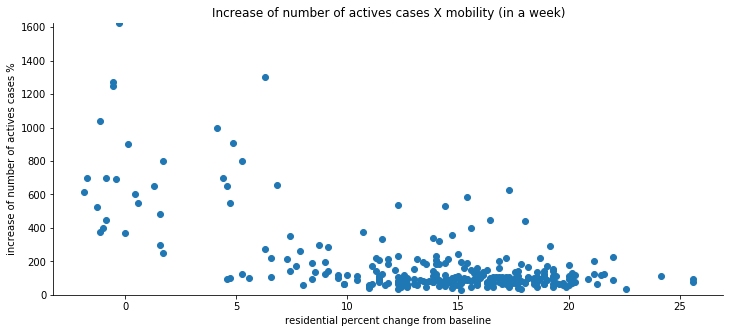

In [26]:
# column that will be plotted
mobilityColumn = 'residential_percent_change_from_baseline'

# data to generate the graph
graphMobility = covidGrouped.reset_index()

# selecting the column of mobility to the x axis
x = graphMobility[mobilityColumn]

# the result will be the increase of number of cases
y = graphMobility.increase*100

fig, ax = plt.subplots(figsize = (12, 5))
ax.set_xlabel(mobilityColumn.replace('_', ' '))
ax.set_ylabel('increase of number of actives cases %')
ax.set_title('Increase of number of actives cases X mobility (in a week)')
ax.set_ylim(0, covidGrouped.increase.max()*100)
ax.scatter(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0)

plt.savefig('archive/increase cases number of actives cases X mobility (in a week)')
plt.show()

The states presented a positive correlation between the increase of mobility on parks, transit stations, workplaces, recreation areas, grocery and pharmacies and the increase of number of active cases of covid, that means that the increase of number of people on that regions increase the number of actives cases. Also a negative correlation between be at home and the increase of number of actives cases, that means that the increase of people at home reduce the increase of active cases. 

### mobility and deaths

The correlation between cases and mobility is shown above, it is known that on average at last 0.7% of people contaminated will not resist, so it exists a correlation between mobility and deaths. Although the deaths will be deslocade on time related the number de cases because the time to COVID cause death is between 14-30 days also take a time for the state declare the death as COVID.

### Prediction for the next 30 days

The number of cases and deaths growth increase exponentially to be capable to predict the number of cases in the future is necessary to do linear regression of the log of the cases and deaths on time.

In [27]:
# selecting necessary columns
covidBrCasesDeath = covidBr.reset_index()[['date', 'last_available_confirmed', 'last_available_deaths', 'new_confirmed', 'new_deaths', 'actives', 'inactives']].groupby('date').sum().reset_index().reset_index().rename({'index':'days'}, axis = 1)

# applying log on the columns of cases and deaths
covidBrCasesDeath['log_last_available_confirmed'] = covidBrCasesDeath['last_available_confirmed'].apply(lambda x: log(x) if x > 0 else 0)
covidBrCasesDeath['log_last_available_deaths'] = covidBrCasesDeath['last_available_deaths'].apply(lambda x: log(x) if x > 0 else 0)
covidBrCasesDeath['log_new_confirmed'] = covidBrCasesDeath['new_confirmed'].apply(lambda x: log(x) if x > 0 else 0)
covidBrCasesDeath['log_new_deaths'] = covidBrCasesDeath['new_deaths'].apply(lambda x: log(x) if x > 0 else 0)
covidBrCasesDeath['log_actives'] = covidBrCasesDeath['actives'].apply(lambda x: log(x) if x > 0 else 0)

(0, 554599.5)

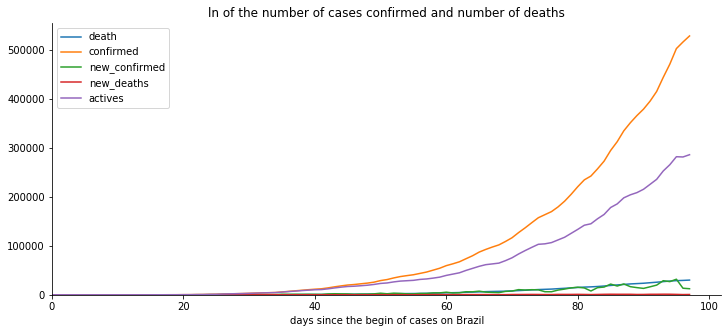

In [28]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.last_available_deaths)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.last_available_confirmed)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.new_confirmed)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.new_deaths)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.actives)
ax.set_xlabel('days since the begin of cases on Brazil')
plt.legend(['death', 'confirmed', 'new_confirmed', 'new_deaths', 'actives'])
plt.title('ln of the number of cases confirmed and number of deaths')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0)
ax.set_ylim(0)

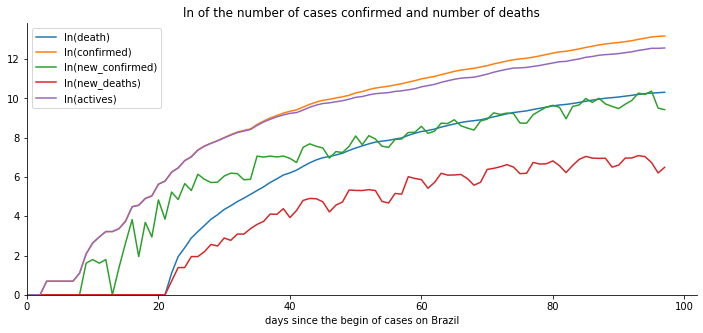

In [29]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.log_last_available_deaths)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.log_last_available_confirmed)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.log_new_confirmed)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.log_new_deaths)
ax.plot(covidBrCasesDeath.index, covidBrCasesDeath.log_actives)
ax.set_xlabel('days since the begin of cases on Brazil')
plt.legend(['ln(death)', 'ln(confirmed)', 'ln(new_confirmed)', 'ln(new_deaths)', 'ln(actives)'])
plt.title('ln of the number of cases confirmed and number of deaths')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0)
ax.set_ylim(0)

plt.savefig('archive/ln_cases_deaths')
plt.show()

After 70 days the log of the number of confirmed and number of deaths have a linear correlation with the time.

In [30]:
dayOfBegin = 70
covidBrCasesDeath[covidBrCasesDeath.index >= dayOfBegin].corr().days.drop('days')

last_available_confirmed        0.987645
last_available_deaths           0.996715
new_confirmed                   0.688031
new_deaths                      0.442786
actives                         0.990229
inactives                       0.982739
log_last_available_confirmed    0.998504
log_last_available_deaths       0.994776
log_new_confirmed               0.713546
log_new_deaths                  0.414288
log_actives                     0.997082
Name: days, dtype: float64

the log of confirmed have a correlation of 0,999 with the time and the death of 0,995. Probability the correlation is smaller on deaths because that death take more time to happen and take more time to be notified. The number of deaths and the number of confirmed cases are linearly dependent with a delay on time (a model to be capable to predict precisely what will happen needs a correlation of 0,9999 at least).

In [31]:
# data to adjust the linear model
xDays = covidBrCasesDeath.reset_index()[covidBrCasesDeath.reset_index().index >= dayOfBegin].index
yConfirmed = covidBrCasesDeath.reset_index()[covidBrCasesDeath.reset_index().index >= dayOfBegin].log_last_available_confirmed
yDeath = covidBrCasesDeath.reset_index()[covidBrCasesDeath.reset_index().index >= dayOfBegin].log_last_available_deaths

In [32]:
# list of the next 30 days
daysPredict = list(range(covidBrCasesDeath.days.max() + 1, covidBrCasesDeath.days.max() + 31))

# prediction of the number of confirmed
linmodelLogConfirmed = LinearRegression(normalize = True)
linmodelLogConfirmed.fit(np.array(xDays).reshape(-1, 1), np.array(yConfirmed))
predictLogConfirmed = linmodelLogConfirmed.predict(np.array(daysPredict).reshape(-1, 1))

# prediction of the number of deaths
linmodelLogDeath = LinearRegression()
linmodelLogDeath.fit(np.array(xDays).reshape(-1, 1), np.array(yDeath))
predictLogDeath = linmodelLogDeath.predict(np.array(daysPredict).reshape(-1, 1))

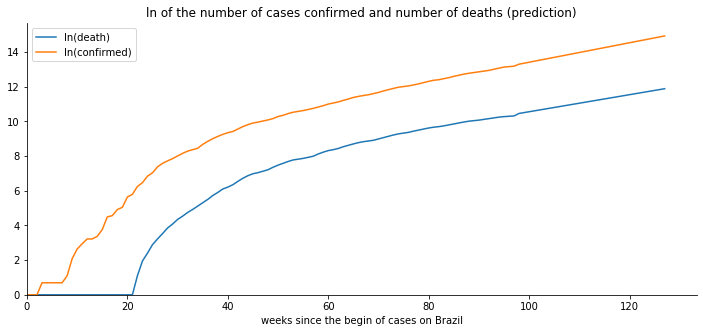

In [33]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(list(covidBrCasesDeath.index) + list(daysPredict), list(covidBrCasesDeath.log_last_available_deaths) + list(predictLogDeath))
ax.plot(list(covidBrCasesDeath.index) + list(daysPredict), list(covidBrCasesDeath.log_last_available_confirmed) + list(predictLogConfirmed))
ax.set_xlabel('weeks since the begin of cases on Brazil')
plt.legend(['ln(death)', 'ln(confirmed)'])
ax.set_title('ln of the number of cases confirmed and number of deaths (prediction)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0)
ax.set_ylim(0)

plt.show()

The prediction is more pessimist that the behavior of the curve, with the time the velocity of increase of number of cases slow down. Even Though we will probably be increasing the number of cases by day in the end of june.

In [34]:
# data frame of result of prediction converted para confirmed and deaths.
startDate = covidBrCasesDeath.date.min() 
datePredict = [startDate + timedelta(days = day) for day in daysPredict]
prediction = pd.DataFrame({'deaths':list(e**predictLogDeath), 'days': datePredict, 'confirmed':list(e**predictLogConfirmed)}).set_index('days').astype({'deaths':'int32', 'confirmed':'int32'})

# computing new cases by day and new deaths    
prediction['new_deaths'] = prediction.index.map(lambda x: (prediction.loc[x, 'deaths'] - prediction.loc[x - timedelta(days = 1), 'deaths']) if (x > prediction.index[0]) else np.NAN)
prediction['new_confirmed'] = prediction.index.map(lambda x: (prediction.loc[x, 'confirmed'] - prediction.loc[x - timedelta(days = 1), 'confirmed']) if (x > prediction.index[0]) else np.NAN)

prediction

,deaths,confirmed,new_deaths,new_confirmed
days,,,,
2020-06-02,34674,593189,NaN,NaN
2020-06-03,36421,627446,1747.0,34257.0
2020-06-04,38257,663681,1836.0,36235.0
2020-06-05,40185,702008,1928.0,38327.0
2020-06-06,42210,742549,2025.0,40541.0
2020-06-07,44337,785432,2127.0,42883.0
2020-06-08,46572,830790,2235.0,45358.0
2020-06-09,48919,878768,2347.0,47978.0
2020-06-10,51384,929517,2465.0,50749.0


The prediction of 6923 deaths per day and 164995 confirmed cases per day, considering that the behavior of the curve remains.